In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.svm import SVC

StatementMeta(, a3698a00-377e-4dcf-b9ad-7256f754dfac, 3, Finished, Available, Finished)

In [2]:
# Cargar las tablas de Microsoft Fabric en Pandas DataFrames
df_circuits = spark.table("circuits").toPandas()
df_constructor_results = spark.table("constructor_results").toPandas()
df_constructor_standings = spark.table("constructor_standings").toPandas()
df_constructors = spark.table("constructors").toPandas()
df_driver_standings = spark.table("driver_standings").toPandas()
df_drivers = spark.table("drivers").toPandas()
df_lap_times = spark.table("lap_times").toPandas()
df_pit_stops = spark.table("pit_stops").toPandas()
df_qualifying = spark.table("qualifying").toPandas()
df_races = spark.table("races").toPandas()
df_results = spark.table("results").toPandas()
df_seasons = spark.table("seasons").toPandas()
df_sprint_results = spark.table("sprint_results").toPandas()
df_status = spark.table("status").toPandas()

StatementMeta(, a3698a00-377e-4dcf-b9ad-7256f754dfac, 4, Finished, Available, Finished)

In [3]:
# Lista de nombres de las tablas y sus respectivos DataFrames
tables = {
    "circuits": df_circuits, 
    "constructor_results": df_constructor_results, 
    "constructor_standings": df_constructor_standings, 
    "constructors": df_constructors,
    "driver_standings": df_driver_standings, 
    "drivers": df_drivers, 
    "lap_times": df_lap_times, 
    "pit_stops": df_pit_stops, 
    "qualifying": df_qualifying,
    "races": df_races,  
    "results": df_results, 
    "seasons": df_seasons, 
    "sprint_results": df_sprint_results, 
    "status": df_status
}

# Iterar sobre cada DataFrame para mostrar su nombre y forma
for table_name, df in tables.items():
    print(f"Tabla: {table_name} - Shape: {df.shape}")

StatementMeta(, a3698a00-377e-4dcf-b9ad-7256f754dfac, 5, Finished, Available, Finished)

Tabla: circuits - Shape: (77, 9)
Tabla: constructor_results - Shape: (12505, 5)
Tabla: constructor_standings - Shape: (13271, 7)
Tabla: constructors - Shape: (212, 5)
Tabla: driver_standings - Shape: (34595, 7)
Tabla: drivers - Shape: (859, 9)
Tabla: lap_times - Shape: (575029, 6)
Tabla: pit_stops - Shape: (10990, 7)
Tabla: qualifying - Shape: (10254, 9)
Tabla: races - Shape: (1125, 18)
Tabla: results - Shape: (26519, 18)
Tabla: seasons - Shape: (75, 2)
Tabla: sprint_results - Shape: (300, 16)
Tabla: status - Shape: (139, 2)


In [4]:
# Leer la tabla registrada en Spark sin necesidad de especificar el path completo
df_raceresults = spark.table("racesresults")

# Convertir el DataFrame de PySpark a Pandas
df_raceresults = df_raceresults.toPandas()

# Mostrar algunas filas en Pandas para verificar la carga
df_raceresults.head(10)

StatementMeta(, a3698a00-377e-4dcf-b9ad-7256f754dfac, 6, Finished, Available, Finished)

,raceId,year,round,circuitId,driverId,constructorId,grid,position,points,statusId,status,laps,fastestLap,fastestLapTime
0,1121,2024,1,3,830,9,1,1,26.0,1,Finished,57,39,1:32.608
1,1121,2024,1,3,815,9,5,2,18.0,1,Finished,57,40,1:34.364
2,1121,2024,1,3,832,6,4,3,15.0,1,Finished,57,44,1:34.507
3,1122,2024,2,77,830,9,1,1,25.0,1,Finished,50,50,1:31.773
4,1122,2024,2,77,815,9,3,2,18.0,1,Finished,50,37,1:32.273
5,1122,2024,2,77,844,6,2,3,16.0,1,Finished,50,50,1:31.632
6,1123,2024,3,1,832,6,2,1,25.0,1,Finished,58,48,1:20.031
7,1123,2024,3,1,844,6,4,2,19.0,1,Finished,58,56,1:19.813
8,1123,2024,3,1,846,1,3,3,15.0,1,Finished,58,1,1:19.915
9,1124,2024,4,22,830,9,1,1,26.0,1,Finished,53,50,1:33.706


In [5]:
# Seleccionar las columnas que serán features
feature_columns = ['raceId', 'year', 'round', 'circuitId', 'driverId', 'constructorId', 'grid', 'points', 'statusId', 'laps', 'fastestLap', 'fastestLapTime']

StatementMeta(, a3698a00-377e-4dcf-b9ad-7256f754dfac, 7, Finished, Available, Finished)

In [6]:
# Seleccionar las columnas de características junto con la columna de la variable objetivo (position)
df_final = df_raceresults[feature_columns + ['position']]

# Mostrar las primeras filas del DataFrame final en Pandas
df_final.head(10)

StatementMeta(, a3698a00-377e-4dcf-b9ad-7256f754dfac, 8, Finished, Available, Finished)

,raceId,year,round,circuitId,driverId,constructorId,grid,points,statusId,laps,fastestLap,fastestLapTime,position
0,1121,2024,1,3,830,9,1,26.0,1,57,39,1:32.608,1
1,1121,2024,1,3,815,9,5,18.0,1,57,40,1:34.364,2
2,1121,2024,1,3,832,6,4,15.0,1,57,44,1:34.507,3
3,1122,2024,2,77,830,9,1,25.0,1,50,50,1:31.773,1
4,1122,2024,2,77,815,9,3,18.0,1,50,37,1:32.273,2
5,1122,2024,2,77,844,6,2,16.0,1,50,50,1:31.632,3
6,1123,2024,3,1,832,6,2,25.0,1,58,48,1:20.031,1
7,1123,2024,3,1,844,6,4,19.0,1,58,56,1:19.813,2
8,1123,2024,3,1,846,1,3,15.0,1,58,1,1:19.915,3
9,1124,2024,4,22,830,9,1,26.0,1,53,50,1:33.706,1


In [54]:
df_final.describe()

StatementMeta(, 6d4f3bf1-eb48-492d-98cd-8a2ce5397511, 56, Finished, Available, Finished)

,raceId,year,round,circuitId,driverId,constructorId,grid,points,statusId,laps,position
count,3360.000000,3360.000000,3360.000000,3360.000000,3360.000000,3360.000000,3360.00000,3360.000000,3360.000000,3360.000000,3360.000000
mean,561.140476,1992.119345,8.442857,23.725595,229.389286,37.428869,4.26250,9.934943,1.573512,64.819643,2.002083
std,324.588787,20.615081,5.070536,19.447864,264.412108,56.302116,3.66336,6.392153,3.135419,20.618573,0.816433
min,1.000000,1950.000000,1.000000,1.000000,1.000000,1.000000,1.00000,0.000000,1.000000,1.000000,1.000000
25%,280.750000,1976.000000,4.000000,9.000000,21.000000,4.000000,2.00000,6.000000,1.000000,54.000000,1.000000
50%,561.000000,1994.000000,8.000000,18.000000,118.000000,6.000000,3.00000,8.000000,1.000000,65.000000,2.000000
75%,834.000000,2010.000000,12.000000,34.000000,341.000000,34.000000,6.00000,15.000000,1.000000,73.000000,3.000000
max,1132.000000,2024.000000,22.000000,80.000000,857.000000,214.000000,32.00000,50.000000,60.000000,200.000000,3.000000


El análisis estadístico descriptivo de las columnas numéricas en el DataFrame muestra información relevante como la media, desviación estándar, valores mínimos y máximos, así como los cuartiles (25%, 50% y 75%). Esto permite observar la distribución de las características clave, como el número de vueltas (laps), la posición de salida (grid), los puntos obtenidos (points), y la variable objetivo (position).

raceId tiene un rango de 1 a 1132, lo que indica una gran cantidad de carreras registradas.

year varía entre 1950 y 2024, cubriendo varias décadas de datos.

grid muestra un valor máximo de 32, que podría corresponder al número de coches que participan en la parrilla de salida.

points muestra una alta variabilidad, con un valor máximo de 50 y una desviación estándar considerable de 6.39 puntos.

La variable objetivo position toma valores de 1 a 3, que corresponden a los tres primeros lugares de cada carrera.

Este análisis sugiere que los datos están bien distribuidos y no presentan anomalías significativas. Estos resultados servirán como una base sólida para construir un modelo de Machine Learning que pueda predecir la posición final basada en estas características.

In [55]:
# Verificar valores nulos
df_final.isnull().sum()

StatementMeta(, 6d4f3bf1-eb48-492d-98cd-8a2ce5397511, 57, Finished, Available, Finished)

raceId            0
year              0
round             0
circuitId         0
driverId          0
constructorId     0
grid              0
points            0
statusId          0
laps              0
fastestLap        0
fastestLapTime    0
position          0
dtype: int64

No se ha encontrado ningún valor nulo en la tabla, lo que indica que los datos están completos y listos para ser utilizados en el análisis o modelo de Machine Learning sin necesidad de realizar imputaciones o tratamientos adicionales para valores faltantes.

In [56]:
# Verificar el tipo de dato de cada columna
print(df_final.dtypes)

StatementMeta(, 6d4f3bf1-eb48-492d-98cd-8a2ce5397511, 58, Finished, Available, Finished)

raceId              int32
year                int32
round               int32
circuitId           int32
driverId            int32
constructorId       int32
grid                int32
points            float64
statusId            int32
laps                int32
fastestLap         object
fastestLapTime     object
position            int32
dtype: object


Observamos que hay dos columnas con el tipo de dato object: fastestLap y fastestLapTime. Dado que estas columnas deberían contener datos numéricos o de tiempo, es necesario transformarlas para que el modelo de Machine Learning pueda manejarlas de manera adecuada. Esto implica convertir fastestLap a un tipo numérico y fastestLapTime a un formato que permita trabajar con tiempos, como timedelta o segundos.

In [57]:
# Verificar el tamaño de la tabla
print(df_final.shape)

StatementMeta(, 6d4f3bf1-eb48-492d-98cd-8a2ce5397511, 59, Finished, Available, Finished)

(3360, 13)


In [58]:
# Contar la cantidad de valores únicos por columna
print(df_final.nunique())

StatementMeta(, 6d4f3bf1-eb48-492d-98cd-8a2ce5397511, 60, Finished, Available, Finished)

raceId            1113
year                75
round               22
circuitId           77
driverId           216
constructorId       76
grid                28
points              28
statusId             7
laps                87
fastestLap          77
fastestLapTime    1179
position             3
dtype: int64


El análisis de los valores únicos por columna muestra la diversidad de datos en cada una de las características. Esto es útil para comprender la variabilidad dentro del conjunto de datos y su potencial impacto en el modelo de Machine Learning. A continuación se destacan algunos puntos clave:

raceId: Hay 1113 carreras distintas en el conjunto de datos.

year: Los datos cubren 75 años diferentes, lo que sugiere una larga trayectoria de competiciones.

round: Existen 22 rondas distintas, lo que puede representar las diferentes etapas dentro de una temporada.

circuitId: Se identifican 77 circuitos únicos, lo cual refleja una amplia variedad de pistas en las que se han realizado las competiciones.

driverId y const****ructorId: Hay 216 pilotos y 76 equipos distintos, lo que muestra la diversidad de participantes en las carreras.

grid y points: Las posiciones de salida y los puntos obtenidos tienen 28 valores únicos, lo que sugiere una considerable variabilidad en la puntuación y la clasificación.

statusId: Solo hay 7 valores de estado diferentes, lo cual puede representar distintos resultados de la carrera (terminado, retirado, etc.).

fastestLapTime: Es notable que hay 1179 valores únicos de tiempos de vuelta más rápida, lo que implica que los tiempos están bastante dispersos y diversos.

position: Como variable objetivo, hay 3 posiciones únicas, probablemente representando los lugares en el podio (primero, segundo, y tercero).

Estos resultados indican que el conjunto de datos tiene una buena mezcla de variabilidad en varias características, lo que puede ayudar al modelo de Machine Learning a aprender patrones más complejos para predecir la posición final.

In [59]:
# Contar la frecuencia de los valores en una columna
print(df_final['position'].value_counts())

StatementMeta(, 6d4f3bf1-eb48-492d-98cd-8a2ce5397511, 61, Finished, Available, Finished)

position
3    1123
2    1121
1    1116
Name: count, dtype: int64


El análisis de la columna position muestra una distribución equilibrada de los tres primeros lugares en las carreras:

Posición 3: 1123 carreras.

Posición 2: 1121 carreras.

Posición 1: 1116 carreras.

Esto indica una representación uniforme de las posiciones en el podio, lo que es favorable para el entrenamiento del modelo de Machine Learning.

Análisis de los campos Features

In [60]:
# Mostrar las columnas del DataFrame
print(df_final.columns)

StatementMeta(, 6d4f3bf1-eb48-492d-98cd-8a2ce5397511, 62, Finished, Available, Finished)

Index(['raceId', 'year', 'round', 'circuitId', 'driverId', 'constructorId',
       'grid', 'points', 'statusId', 'laps', 'fastestLap', 'fastestLapTime',
       'position'],
      dtype='object')


**Análisis de cada campo**

In [7]:
def analizar_columna(df, columna):
    # Contar el número total de valores en la columna
    total_valores = df[columna].count()
    
    # Contar el número de valores únicos en la columna
    valores_unicos = df[columna].nunique()
    
    # Revisar los valores únicos de la columna
    valores_unicos_list = df[columna].unique()
    
    # Contar el número de valores duplicados en la columna
    valores_duplicados = total_valores - valores_unicos
    
    # Verificar y contar los valores no numéricos en la columna
    no_numericos = df[~df[columna].apply(lambda x: isinstance(x, (int, float)))]
    total_no_numericos = no_numericos.shape[0]
    
    # Mostrar los resultados
    print(f"Análisis de la columna '{columna}':")
    print(f"Total de valores en '{columna}': {total_valores}")
    print(f"Valores únicos en '{columna}': {valores_unicos}")
    print(f"Valores duplicados en '{columna}': {valores_duplicados}")
    
    # Imprimir los valores únicos para revisarlos
    print(f"Valores únicos en '{columna}': {valores_unicos_list}")
    print("-" * 50)
    
    # Mostrar el conteo de los valores no numéricos si existen
    if total_no_numericos > 0:
        print(f"Total de valores no numéricos en la columna '{columna}': {total_no_numericos}")
    else:
        print(f"No se encontraron valores no numéricos en la columna '{columna}'")
    print("-" * 50)

StatementMeta(, e68be33d-46e3-461f-9bc2-0965089faf89, 9, Finished, Available, Finished)

**raceId**

In [6]:
# Usar la función para una columna específica, por ejemplo 'raceId'
analizar_columna(df_final, 'raceId')

StatementMeta(, 2befbbb4-00dc-4386-a083-11536325cccd, 8, Finished, Available, Finished)

Análisis de la columna 'raceId':
Total de valores en 'raceId': 3360
Valores únicos en 'raceId': 1113
Valores duplicados en 'raceId': 2247
Valores únicos en 'raceId': [1121 1122 1123 ...  837  838  839]
--------------------------------------------------
No se encontraron valores no numéricos en la columna 'raceId'
--------------------------------------------------


La alta cantidad de valores duplicados es normal, ya que una misma carrera (raceId) puede tener múltiples registros para diferentes pilotos, posiciones y otros datos. Esto es esperable en un dataset que almacena múltiples resultados por carrera. El hecho de tener una gran cantidad de valores únicos muestra que se está trabajando con datos de un número considerable de carreras, lo cual es positivo para el análisis.

**year**

In [7]:
analizar_columna(df_final, 'year')

StatementMeta(, 2befbbb4-00dc-4386-a083-11536325cccd, 9, Finished, Available, Finished)

Análisis de la columna 'year':
Total de valores en 'year': 3360
Valores únicos en 'year': 75
Valores duplicados en 'year': 3285
Valores únicos en 'year': [2024 2023 2022 2021 2020 2019 2018 2017 2016 2015 2014 2013 2012 2011
 2010 2009 2008 2007 2006 2005 2004 2003 2002 2001 2000 1999 1998 1997
 1996 1995 1994 1993 1992 1991 1990 1989 1988 1987 1986 1985 1984 1983
 1982 1981 1980 1979 1978 1977 1976 1975 1974 1973 1972 1971 1970 1969
 1968 1967 1966 1965 1964 1963 1962 1961 1960 1959 1958 1957 1956 1955
 1954 1953 1952 1951 1950]
--------------------------------------------------
No se encontraron valores no numéricos en la columna 'year'
--------------------------------------------------


Esto indica que la columna 'year' contiene una amplia cantidad de valores repetidos, lo cual es lógico ya que se espera que haya múltiples registros correspondientes a un mismo año en diferentes carreras. Los valores duplicados son simplemente registros de distintos eventos que ocurrieron en los mismos años. Este comportamiento es esperado para columnas como 'year', 'raceId' o cualquier columna que represente categorías o eventos repetidos en diferentes años.



**round**

In [136]:
analizar_columna(df_final, 'round')

StatementMeta(, 6d4f3bf1-eb48-492d-98cd-8a2ce5397511, 138, Finished, Available, Finished)

Análisis de la columna 'round':
Total de valores en 'round': 3360
Valores únicos en 'round': 22
Valores duplicados en 'round': 3338
Valores únicos en 'round': [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22]
--------------------------------------------------
No se encontraron valores no numéricos en la columna 'round'
--------------------------------------------------


Esto indica que la columna 'round' tiene un conjunto limitado de valores únicos, lo cual es de esperarse dado que representa el número de la ronda en las carreras de cada temporada. Cada ronda se repite en diferentes años, lo que explica la gran cantidad de valores duplicados.



**circuitId**

In [137]:
analizar_columna(df_final, 'circuitId')

StatementMeta(, 6d4f3bf1-eb48-492d-98cd-8a2ce5397511, 139, Finished, Available, Finished)

Análisis de la columna 'circuitId':
Total de valores en 'circuitId': 3360
Valores únicos en 'circuitId': 77
Valores duplicados en 'circuitId': 3283
Valores únicos en 'circuitId': [ 3 77  1 22 17 79 21  6  7  4 70  9 73 11 13 39 14 15 78 69 32 18 80 24
 34 75 71  5 76 20 10  2 35 68 12  8 16 19 25 26 27 28 29 30 31 33 36 37
 38 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62
 63 64 65 66 67]
--------------------------------------------------
No se encontraron valores no numéricos en la columna 'circuitId'
--------------------------------------------------


Esto indica que varios circuitos se repiten en las carreras, lo cual es común en los datos de competencias que se realizan en los mismos lugares a lo largo de los años.



**driverId**

In [138]:
analizar_columna(df_final, 'driverId')

StatementMeta(, 6d4f3bf1-eb48-492d-98cd-8a2ce5397511, 140, Finished, Available, Finished)

Análisis de la columna 'driverId':
Total de valores en 'driverId': 3360
Valores únicos en 'driverId': 216
Valores duplicados en 'driverId': 3144
Valores únicos en 'driverId': [830 815 832 844 846 857 847   1   4 839 842 822  20 817 840 848 826   8
   3  13 154 825  18  17 813  30 155 808   2   9  22  15  10  21   5  14
  12  25  23  31  37  33  11  49  56  35  57  63  65  71  55  77  44  84
  81  78  87 103  50  95 117 102 119 121 137 109 131 123 145 122  90  88
 127 105 158 110 140 170 172 177 173 175 182 166 118 163 187 199 202 203
 207 178 152 224 219 221 222 197 223 238 231 250 255 200 233 252 235 230
 304 306 305 327 328 309 332 262 278 345 346 314 320 288 356 360 358 280
 243 317 289 361 341 373 312 370 376 359 340 364 385 387 375 386 374 397
 383 408 401 403 475 476 394 404 479 477 427 509 449 510 482 435 512 347
 418 577 578 581 501 554 525 591 533 590 456 579 496 611 559 528 632 607
 608 606 541 498 642 620 628 529 555 653 648 641 657 658 626 670 478 647
 633 656 518 697 723 5

Los resultados reflejan que muchos pilotos han competido en múltiples carreras, lo cual es normal en una competición de carreras con participantes recurrentes a lo largo del tiempo.

**constructorId**

In [139]:
analizar_columna(df_final, 'constructorId')

StatementMeta(, 6d4f3bf1-eb48-492d-98cd-8a2ce5397511, 141, Finished, Available, Finished)

Análisis de la columna 'constructorId':
Total de valores en 'constructorId': 3360
Valores únicos en 'constructorId': 76
Valores duplicados en 'constructorId': 3284
Valores únicos en 'constructorId': [  9   6   1 131 117 214 213   3 211   4   5  10 208  15  23   7   2  11
  17  16  19  22  24  20  21  27  29  25  35  41  33  37  34  46  32  53
  51  56  59  58  67  64 202  66  63  82 200 180 187 196 182 191 195 167
 170 176 190 172 183 181  95  26 107 108 110  87 118 113 105 114 109 125
 132 128 150 154]
--------------------------------------------------
No se encontraron valores no numéricos en la columna 'constructorId'
--------------------------------------------------


Esto sugiere que hay una cantidad limitada de equipos constructores que han participado en múltiples carreras a lo largo del tiempo, lo que es esperado en competiciones donde los equipos participan de forma recurrente en varias temporadas.

**grid**

In [140]:
analizar_columna(df_final, 'grid')

StatementMeta(, 6d4f3bf1-eb48-492d-98cd-8a2ce5397511, 142, Finished, Available, Finished)

Análisis de la columna 'grid':
Total de valores en 'grid': 3360
Valores únicos en 'grid': 28
Valores duplicados en 'grid': 3332
Valores únicos en 'grid': [ 1  5  4  3  2  7 15  9 12  6 10 11  8 14 19 20 18 16 21 13 22 17 24 23
 26 25 32 28]
--------------------------------------------------
No se encontraron valores no numéricos en la columna 'grid'
--------------------------------------------------


Esto indica que las posiciones iniciales en la parrilla de salida se repiten a lo largo de diferentes carreras, lo que es común, ya que los números de salida suelen estar limitados al número de participantes en cada carrera.

**points**

In [141]:
analizar_columna(df_final, 'points')

StatementMeta(, 6d4f3bf1-eb48-492d-98cd-8a2ce5397511, 143, Finished, Available, Finished)

Análisis de la columna 'points':
Total de valores en 'points': 3360
Valores únicos en 'points': 28
Valores duplicados en 'points': 3332
Valores únicos en 'points': [26.   18.   15.   25.   16.   19.   12.5   9.    7.5  50.   36.   30.
 10.    8.    6.    5.    4.    3.    2.    4.5   0.    6.5   7.    1.33
  8.14  6.14  4.14  8.5 ]
--------------------------------------------------
No se encontraron valores no numéricos en la columna 'points'
--------------------------------------------------


Esto sugiere que las puntuaciones tienden a repetirse entre diferentes carreras, probablemente debido a las reglas de asignación de puntos que se aplican consistentemente en las posiciones de las carreras.

**statusId**

In [142]:
analizar_columna(df_final, 'statusId')

StatementMeta(, 6d4f3bf1-eb48-492d-98cd-8a2ce5397511, 144, Finished, Available, Finished)

Análisis de la columna 'statusId':
Total de valores en 'statusId': 3360
Valores únicos en 'statusId': 7
Valores duplicados en 'statusId': 3353
Valores únicos en 'statusId': [ 1 11 60 12  3 13 14]
--------------------------------------------------
No se encontraron valores no numéricos en la columna 'statusId'
--------------------------------------------------


In [8]:
# Obtener los significados de cada statusId
status_id_mapping = df_raceresults[['statusId', 'status']].drop_duplicates()

# Obtener los conteos de cada statusId
status_id_counts = df_raceresults['statusId'].value_counts().reset_index()
status_id_counts.columns = ['statusId', 'count']

# Combinar los conteos con los significados
status_counts_with_meanings = pd.merge(status_id_counts, status_id_mapping, on='statusId', how='left')

# Mostrar el resultado
print(status_counts_with_meanings)


StatementMeta(, 2befbbb4-00dc-4386-a083-11536325cccd, 10, Finished, Available, Finished)

   statusId  count       status
0         1   3194     Finished
1        11    128       +1 Lap
2        12     25      +2 Laps
3        60      5  Out of fuel
4        13      5      +3 Laps
5         3      2     Accident
6        14      1      +4 Laps


Esto indica que el estado de los resultados de las carreras es bastante repetitivo, probablemente categorizando de manera similar los estados de los corredores en cada carrera.

**laps**

In [143]:
analizar_columna(df_final, 'laps')

StatementMeta(, 6d4f3bf1-eb48-492d-98cd-8a2ce5397511, 145, Finished, Available, Finished)

Análisis de la columna 'laps':
Total de valores en 'laps': 3360
Valores únicos en 'laps': 87
Valores duplicados en 'laps': 3273
Valores únicos en 'laps': [ 57  50  58  53  56  63  78  70  66  71  52  51  44  72  62  64  59  28
   1  60  87  55  61  68  67  69  43  54  49  31  76  65  73  77  45  36
  75  83  81  79  82  14  80  42  74  40  47  29  32  84  85  96  95  90
  89  38  12 108  88 106 107 100  99  98  15  27  48  46 110  97 105 102
 109  86  30 200  35  24 103  22  18 101  94  20 138 137  41]
--------------------------------------------------
No se encontraron valores no numéricos en la columna 'laps'
--------------------------------------------------


Esto indica que hay 87 diferentes cantidades de vueltas completadas en las carreras, y la mayoría de los valores se repiten, lo cual es esperado en este tipo de datos, ya que las vueltas suelen ser similares o iguales en las carreras. 

**fastestLap**

In [144]:
analizar_columna(df_final, 'fastestLap')

StatementMeta(, 6d4f3bf1-eb48-492d-98cd-8a2ce5397511, 146, Finished, Available, Finished)

Análisis de la columna 'fastestLap':
Total de valores en 'fastestLap': 3360
Valores únicos en 'fastestLap': 77
Valores duplicados en 'fastestLap': 3283
Valores únicos en 'fastestLap': ['39' '40' '44' '50' '37' '48' '56' '1' '35' '46' '33' '55' '38' '54' '27'
 '\\N' '70' '67' '51' '45' '43' '36' '49' '53' '57' '23' '41' '61' '62'
 '68' '47' '71' '52' '42' '32' '31' '30' '58' '64' '63' '69' '29' '72'
 '59' '10' '11' '65' '60' '76' '34' '28' '66' '75' '85' '14' '9' '24' '26'
 '21' '22' '13' '15' '25' '19' '5' '74' '77' '78' '17' '18' '16' '20' '12'
 '4' '8' '6' '7']
--------------------------------------------------
Total de valores no numéricos en la columna 'fastestLap': 3360
--------------------------------------------------


In [146]:
(df_final['fastestLap'] == '\\N').sum()

StatementMeta(, 6d4f3bf1-eb48-492d-98cd-8a2ce5397511, 148, Finished, Available, Finished)

2166

El número de valores nulos o inválidos en el campo fastestLap es considerablemente alto (2166 sobre 3360). Este porcentaje significativo de valores faltantes sugiere que se debe evaluar cuidadosamente si incluir o no este campo en el análisis o modelo.

**fastestLapTime**

In [147]:
analizar_columna(df_final, 'fastestLapTime')

StatementMeta(, 6d4f3bf1-eb48-492d-98cd-8a2ce5397511, 149, Finished, Available, Finished)

Análisis de la columna 'fastestLapTime':
Total de valores en 'fastestLapTime': 3360
Valores únicos en 'fastestLapTime': 1179
Valores duplicados en 'fastestLapTime': 2181
Valores únicos en 'fastestLapTime': ['1:32.608' '1:34.364' '1:34.507' ... '1:11.473' '1:11.562' '1:11.672']
--------------------------------------------------
Total de valores no numéricos en la columna 'fastestLapTime': 3360
--------------------------------------------------


In [150]:
(df_final['fastestLapTime'] == '\\N').sum()

StatementMeta(, 6d4f3bf1-eb48-492d-98cd-8a2ce5397511, 152, Finished, Available, Finished)

2166

**position**

In [8]:
analizar_columna(df_final, 'position')

StatementMeta(, e68be33d-46e3-461f-9bc2-0965089faf89, 10, Finished, Available, Finished)

Análisis de la columna 'position':
Total de valores en 'position': 3360
Valores únicos en 'position': 3
Valores duplicados en 'position': 3357
Valores únicos en 'position': [1 2 3]
--------------------------------------------------
No se encontraron valores no numéricos en la columna 'position'
--------------------------------------------------


Esta columna está lista para ser usada como la variable objetivo en el modelo de Machine Learning, ya que representa la clasificación final de los corredores.

In [9]:
# Contar la frecuencia de cada posición en la tabla 'results'
position_counts = df_results['position'].value_counts().reset_index()

# Renombrar las columnas para mayor claridad
position_counts.columns = ['position', 'count']

# Mostrar el resultado
print(position_counts)

StatementMeta(, e68be33d-46e3-461f-9bc2-0965089faf89, 11, Finished, Available, Finished)

   position  count
0        \N  10928
1         4   1123
2         3   1123
3         2   1121
4         5   1119
5         1   1116
6         6   1112
7         7   1092
8         8   1064
9         9   1026
10       10    966
11       11    889
12       12    788
13       13    701
14       14    593
15       15    516
16       16    422
17       17    326
18       18    215
19       19    135
20       20     71
21       21     34
22       22     19
23       23      8
24       24      3
25       25      1
26       28      1
27       33      1
28       29      1
29       31      1
30       32      1
31       26      1
32       27      1
33       30      1


**MODELO**

Comenzare a trabajar con un modelos sencillo sin estas 2 columnas

In [8]:
# Eliminar los campos 'fastestLapTime' y 'fastestLap' del dataset
df_modelo = df_final.drop(columns=['fastestLapTime', 'fastestLap'])

# Verificar que las columnas han sido eliminadas
df_modelo

StatementMeta(, a3698a00-377e-4dcf-b9ad-7256f754dfac, 10, Finished, Available, Finished)

,raceId,year,round,circuitId,driverId,constructorId,grid,points,statusId,laps,position
0,1121,2024,1,3,830,9,1,26.0,1,57,1
1,1121,2024,1,3,815,9,5,18.0,1,57,2
2,1121,2024,1,3,832,6,4,15.0,1,57,3
3,1122,2024,2,77,830,9,1,25.0,1,50,1
4,1122,2024,2,77,815,9,3,18.0,1,50,2
...,...,...,...,...,...,...,...,...,...,...,...
3355,838,1950,6,55,687,6,18,4.0,13,61,3
3356,839,1950,7,14,642,51,3,8.0,1,80,1
3357,839,1950,7,14,802,6,6,3.0,1,80,2
3358,839,1950,7,14,647,6,6,3.0,1,80,2


-----

**Configuración del experimento de aprendizaje automático en Microsoft Fabric**

In [9]:
import mlflow
import mlflow.sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from mlflow.models.signature import infer_signature

# Configurar el experimento
mlflow.set_experiment("sample_rfC")

# Definir las características (X) y la variable objetivo (y)
X = df_modelo.drop(columns=['position'])  # Características
y = df_modelo['position']  # Variable objetivo

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenar el modelo y registrar con MLFlow
with mlflow.start_run() as run:
    # Crear y entrenar el modelo
    model = RandomForestClassifier(max_depth=5, random_state=42)
    model.fit(X_train, y_train)

    # Hacer predicciones
    y_pred = model.predict(X_test)
    score = model.score(X_test, y_test)  # Calcular la precisión

    # Registrar la métrica y parámetros del modelo
    mlflow.log_metric("accuracy", score)
    mlflow.log_param("max_depth", 5)
    mlflow.log_param("random_state", 42)

    # Guardar el modelo con el nombre "sample_rfC"
    signature = infer_signature(X_train, y_train)
    mlflow.sklearn.log_model(model, "sample_rfC", signature=signature)
    print("Modelo guardado con run_id=%s" % run.info.run_id)

    # Registrar el modelo en MLFlow para seguimiento futuro con el nombre "sample_rfC"
    mlflow.register_model(
        "runs:/{}/sample_rfC".format(run.info.run_id), "sample_rfC"
    )
    print("Todo listo")


StatementMeta(, a3698a00-377e-4dcf-b9ad-7256f754dfac, 11, Finished, Available, Finished)

/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/mlflow/types/utils.py:393: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/_distutils_hack/__init__.py:26: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distuti

Modelo guardado con run_id=46b4789a-ef59-4852-a5a7-9d998d7a232b
Todo listo


Cargar el modelo y realizar inferencias

In [11]:
import mlflow.sklearn

# Cargar el modelo registrado
modelo_cargado = mlflow.sklearn.load_model("models:/sample_rfC/1")

# Hacer predicciones
y_pred = modelo_cargado.predict(X_test)

# Mostrar las predicciones
print(y_pred)

StatementMeta(, a3698a00-377e-4dcf-b9ad-7256f754dfac, 13, Finished, Available, Finished)

[2 2 2 3 2 3 3 2 1 2 3 1 1 1 1 2 1 3 2 3 3 1 3 3 2 1 2 3 1 3 3 2 3 2 2 3 2
 3 2 1 3 3 2 2 3 1 1 1 1 3 2 1 3 3 1 1 1 3 2 1 3 1 1 3 2 1 1 1 1 1 3 1 3 3
 2 1 2 2 2 1 1 1 3 2 1 1 2 1 2 2 3 1 1 2 1 2 1 3 3 2 1 3 3 2 1 1 1 3 3 3 1
 2 2 3 2 2 2 1 2 2 3 3 1 3 3 1 1 2 3 1 1 2 2 1 3 1 1 2 3 3 3 1 1 1 1 3 1 1
 2 2 3 2 2 1 3 2 2 2 1 1 2 2 3 3 3 1 1 1 3 1 2 1 2 3 1 1 3 3 3 2 2 1 1 3 2
 1 3 2 1 1 1 2 3 3 3 1 3 3 1 2 1 1 3 1 3 2 1 2 2 1 2 2 2 1 2 2 2 2 3 1 3 1
 2 3 3 3 3 2 1 2 1 1 3 1 1 2 3 1 1 1 2 3 1 1 2 2 3 1 1 3 3 1 2 2 2 1 1 2 3
 2 3 2 3 3 2 1 3 1 2 2 1 3 3 3 2 2 2 1 2 2 2 1 3 1 3 3 3 3 3 3 3 3 1 3 3 2
 1 3 1 1 3 1 1 3 2 3 3 3 3 2 3 2 2 3 1 2 1 3 1 1 3 2 1 2 3 2 2 1 1 1 3 3 1
 1 2 3 3 3 1 2 3 2 2 1 2 3 1 2 1 3 1 1 3 2 1 3 2 3 3 3 3 2 1 1 1 3 3 1 3 1
 3 3 3 3 3 1 2 3 3 2 3 3 1 1 3 2 1 1 3 2 2 1 2 1 2 1 1 1 2 3 3 1 2 2 2 2 1
 3 3 3 1 2 3 3 1 3 1 2 1 1 3 1 3 1 3 1 2 2 2 1 2 1 3 2 2 3 2 3 2 1 1 2 1 3
 1 2 2 3 3 1 2 1 1 3 1 3 3 3 3 3 1 2 2 1 2 2 1 1 3 3 3 2 1 2 2 2 3 3 3 3 1
 3 1 2 2 1 2 2 1 1 1 1 2 

StatementMeta(, a3698a00-377e-4dcf-b9ad-7256f754dfac, 14, Finished, Available, Finished)

-----


In [8]:
# Definir las características (X) y la variable objetivo (y)
X = df_modelo.drop(columns=['position'])  # Características, eliminamos la columna objetivo
y = df_modelo['position']  # Variable objetivo

StatementMeta(, 1cde3a7a-90d2-434b-abb5-25854137a9cc, 10, Finished, Available, Finished)

In [9]:
# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


StatementMeta(, 1cde3a7a-90d2-434b-abb5-25854137a9cc, 11, Finished, Available, Finished)

In [10]:
# Entrenar un modelo básico (RandomForestClassifier en este caso)
model = RandomForestClassifier(max_depth=5, random_state=42)
model.fit(X_train, y_train)

StatementMeta(, 1cde3a7a-90d2-434b-abb5-25854137a9cc, 12, Finished, Available, Finished)

RandomForestClassifier(max_depth=5, random_state=42)

In [11]:
# Hacer predicciones en el conjunto de prueba
y_pred = model.predict(X_test)

StatementMeta(, 1cde3a7a-90d2-434b-abb5-25854137a9cc, 13, Finished, Available, Finished)

In [12]:
# Evaluar el modelo (precisión)
accuracy = accuracy_score(y_test, y_pred)
print(f"Precisión del modelo: {accuracy:.4f}")

StatementMeta(, 1cde3a7a-90d2-434b-abb5-25854137a9cc, 14, Finished, Available, Finished)

Precisión del modelo: 0.9598


StatementMeta(, 1cde3a7a-90d2-434b-abb5-25854137a9cc, 15, Finished, Available, Finished)

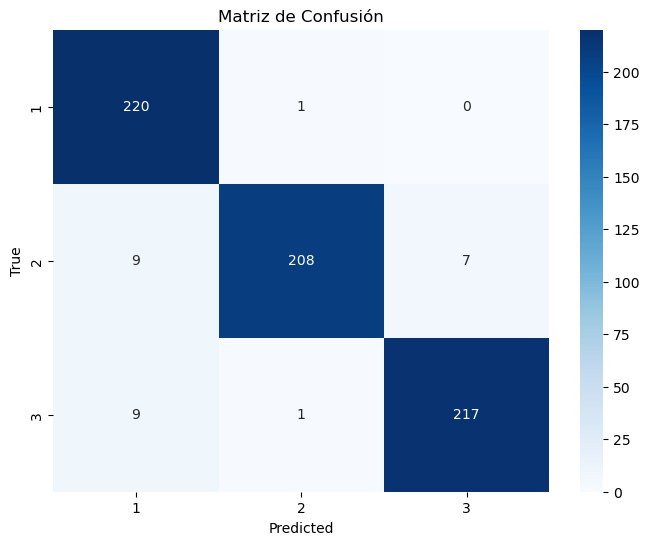

In [13]:
# Generar la matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Visualizar la matriz de confusión con un heatmap
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Matriz de Confusión')
plt.show()

La matriz de confusión muestra una precisión sorprendentemente alta, con muy pocos errores entre las clases. Este nivel de perfección sugiere posibles problemas como el sobreajuste del modelo o una incorrecta separación de los datos de entrenamiento y prueba, lo que podría estar llevando al modelo a "memorizar" en lugar de generalizar. 

In [14]:
# Calcular la precisión global (accuracy)
accuracy = accuracy_score(y_test, y_pred)
print(f"Precisión global (Accuracy): {accuracy:.4f}")

# Calcular precision, recall, f1-score para cada clase
precision = precision_score(y_test, y_pred, average='weighted')  # Usa 'weighted' para multiclase
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Precisión (Precision): {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# Mostrar un informe completo
print("\nInforme de clasificación (Classification Report):")
print(classification_report(y_test, y_pred))

StatementMeta(, 1cde3a7a-90d2-434b-abb5-25854137a9cc, 16, Finished, Available, Finished)

Precisión global (Accuracy): 0.9598
Precisión (Precision): 0.9614
Recall: 0.9598
F1-Score: 0.9598

Informe de clasificación (Classification Report):
              precision    recall  f1-score   support

           1       0.92      1.00      0.96       221
           2       0.99      0.93      0.96       224
           3       0.97      0.96      0.96       227

    accuracy                           0.96       672
   macro avg       0.96      0.96      0.96       672
weighted avg       0.96      0.96      0.96       672



El informe de clasificación muestra una precisión global del 95.98%, lo cual sigue siendo un valor alto, pero más realista que los resultados anteriores. La precisión, recall y F1-score son consistentes en las tres clases, con la clase 1 mostrando un recall perfecto (1.00), mientras que la clase 2 tiene un recall más bajo (0.93). La clase 3 presenta un buen equilibrio entre precisión (0.97) y recall (0.96).

Aunque el modelo está funcionando bien, aún podría estar ligeramente sobreajustado, ya que sigue mostrando resultados muy elevados.

**Analizar el overfit**

In [13]:
print(df_modelo['position'].value_counts())

StatementMeta(, 368adb01-9d77-4bc4-ac09-767824b0e58f, 15, Finished, Available, Finished)

position
3    1123
2    1121
1    1116
Name: count, dtype: int64


Este equilibrio indica que no hay un problema de desbalance de clases que pueda estar afectando el rendimiento del modelo. A pesar de esto, los resultados de evaluación, aunque razonables, siguen siendo bastante altos. Esto podría deberse a factores como la correlación fuerte entre las características o sobreajuste en el modelo.

Análisis de correlación

StatementMeta(, 368adb01-9d77-4bc4-ac09-767824b0e58f, 16, Finished, Available, Finished)

                 raceId      year     round  circuitId  driverId  \
raceId         1.000000  0.082906  0.027835   0.266992  0.622912   
year           0.082906  1.000000  0.336538  -0.191595 -0.135663   
round          0.027835  0.336538  1.000000   0.114234 -0.075017   
circuitId      0.266992 -0.191595  0.114234   1.000000  0.232487   
driverId       0.622912 -0.135663 -0.075017   0.232487  1.000000   
constructorId  0.427095 -0.154741 -0.089245   0.133485  0.168481   
grid          -0.022039 -0.167673 -0.052691   0.040746  0.053693   
points         0.577233  0.684018  0.226632  -0.009520  0.166036   
statusId       0.015025 -0.178283 -0.102531   0.031192  0.055227   
laps           0.022914 -0.244390 -0.184238   0.032853  0.103423   
position       0.001878 -0.004702 -0.002740  -0.001970  0.047849   

               constructorId      grid    points  statusId      laps  position  
raceId              0.427095 -0.022039  0.577233  0.015025  0.022914  0.001878  
year               -0

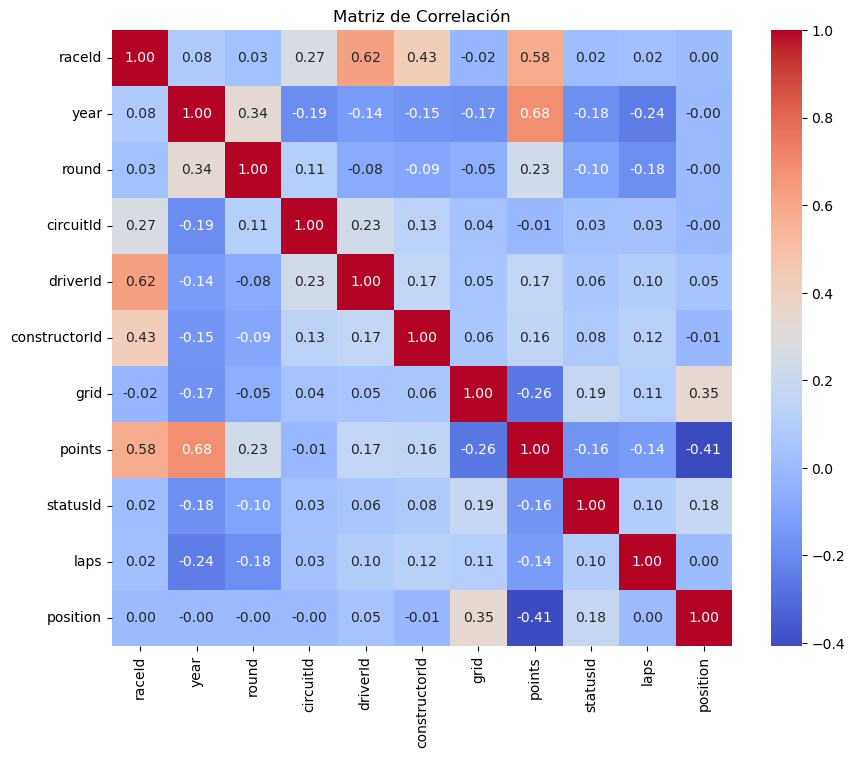

In [14]:
# Calcular la matriz de correlación
correlation_matrix = df_modelo.corr()

# Imprimir la matriz de correlación
print(correlation_matrix)

# Visualizar la matriz de correlación con un heatmap
plt.figure(figsize=(10,8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de Correlación')
plt.show()

**Correlación de position con otras variables:**

La característica que muestra una correlación más fuerte con la posición es points con un valor de -0.41. Esto indica que a medida que aumentan los puntos, la posición mejora (disminuye el valor numérico). Esto tiene sentido, ya que los pilotos que obtienen más puntos suelen tener mejores posiciones.
La segunda correlación más alta es con grid (0.35). Esto sugiere que el lugar en la parrilla de salida tiene una influencia moderada en la posición final.
Variables altamente correlacionadas entre sí:

raceId y driverId tienen una correlación de 0.62, lo que sugiere que estas variables podrían estar proporcionando información similar. Podrías considerar eliminar una de ellas para reducir la redundancia.
year y points tienen una correlación de 0.68, lo que podría indicar una relación histórica en la obtención de puntos a lo largo del tiempo.
Otras correlaciones interesantes:

grid tiene una correlación negativa con points (-0.26), lo que implica que los pilotos que comienzan en una mejor posición (menor número en grid) tienden a obtener más puntos.
statusId y position tienen una correlación de 0.18, lo que sugiere que el estado de carrera también puede influir en la posición final, aunque no de manera tan significativa.

**Importancia de características**

In [15]:
# Obtener la importancia de características
importances = model.feature_importances_

# Crear un DataFrame para visualizar las características más importantes
import pandas as pd
feature_importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
})

# Ordenar las características por importancia de mayor a menor
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Mostrar las características más importantes
print(feature_importances)

StatementMeta(, 368adb01-9d77-4bc4-ac09-767824b0e58f, 17, Finished, Available, Finished)

         Feature  Importance
7         points    0.689092
6           grid    0.123987
1           year    0.059108
0         raceId    0.048747
4       driverId    0.030543
8       statusId    0.020242
5  constructorId    0.011141
9           laps    0.006845
3      circuitId    0.006777
2          round    0.003518


**Grid Search**

In [16]:
# Definir los hiperparámetros a probar
param_grid = {
    'n_estimators': [50, 100, 200],           # Número de árboles
    'max_depth': [None, 5, 10, 20],           # Profundidad máxima de los árboles
    'min_samples_split': [2, 5, 10],          # Número mínimo de muestras para dividir un nodo
    'min_samples_leaf': [1, 2, 4],            # Muestras mínimas por hoja
    'bootstrap': [True, False]                # Si se usa muestreo con reemplazo
}

# Instanciar el modelo RandomForestClassifier
rf = RandomForestClassifier(random_state=42)

# Búsqueda en cuadrícula con validación cruzada
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)

# Ajustar el modelo con los mejores hiperparámetros
grid_search.fit(X_train, y_train)

StatementMeta(, 368adb01-9d77-4bc4-ac09-767824b0e58f, 18, Finished, Available, Finished)

Fitting 3 folds for each of 216 candidates, totalling 648 fits
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total tim

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [None, 5, 10, 20],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             verbose=2)

In [17]:
# Mostrar los mejores hiperparámetros encontrados
print(f"Mejores hiperparámetros: {grid_search.best_params_}")
print(f"Mejor score: {grid_search.best_score_:.4f}")

StatementMeta(, 368adb01-9d77-4bc4-ac09-767824b0e58f, 19, Finished, Available, Finished)

Mejores hiperparámetros: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 50}
Mejor score: 0.9907


In [18]:

# Ajustar el modelo con los mejores hiperparámetros
best_model = RandomForestClassifier(
    bootstrap=False,
    max_depth=None,
    min_samples_leaf=2,
    min_samples_split=2,
    n_estimators=50,
    random_state=42
)

# Entrenar el modelo final
best_model.fit(X_train, y_train)

# Evaluar el modelo en el conjunto de prueba
y_pred = best_model.predict(X_test)

# Calcular la precisión
from sklearn.metrics import accuracy_score, classification_report
accuracy = accuracy_score(y_test, y_pred)
print(f"Precisión en el conjunto de prueba: {accuracy:.4f}")

# Mostrar el informe de clasificación
print("\nInforme de clasificación:")
print(classification_report(y_test, y_pred))


StatementMeta(, 368adb01-9d77-4bc4-ac09-767824b0e58f, 20, Finished, Available, Finished)

Precisión en el conjunto de prueba: 0.9926

Informe de clasificación:
              precision    recall  f1-score   support

           1       1.00      0.99      1.00       221
           2       0.99      0.99      0.99       224
           3       0.99      1.00      0.99       227

    accuracy                           0.99       672
   macro avg       0.99      0.99      0.99       672
weighted avg       0.99      0.99      0.99       672



**Comparar el rendimiento en el conjunto de entrenamiento vs prueba:**

Si el rendimiento del modelo en el conjunto de entrenamiento es muy similar o incluso más alto que en el conjunto de prueba, podría indicar sobreajuste. Un modelo sobreajustado memoriza los datos de entrenamiento, lo que lleva a un rendimiento alto en el entrenamiento pero puede fallar en generalizar para nuevos datos.

In [19]:
# Evaluar el modelo en el conjunto de entrenamiento
y_train_pred = best_model.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)
print(f"Precisión en el conjunto de entrenamiento: {train_accuracy:.4f}")

# Evaluar el modelo en el conjunto de prueba
y_test_pred = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Precisión en el conjunto de prueba: {test_accuracy:.4f}")


StatementMeta(, 368adb01-9d77-4bc4-ac09-767824b0e58f, 21, Finished, Available, Finished)

Precisión en el conjunto de entrenamiento: 1.0000
Precisión en el conjunto de prueba: 0.9926


**Validación cruzada:**
Ya hiciste un ajuste de hiperparámetros con validación cruzada, lo cual es útil para evitar el sobreajuste. Sin embargo, puedes verificar si el modelo generaliza bien realizando nuevamente la validación cruzada con los mejores hiperparámetros y comparando el rendimiento entre las diferentes particiones.

In [20]:
# Realizar validación cruzada
cv_scores = cross_val_score(best_model, X_train, y_train, cv=5)
print(f"Puntajes de validación cruzada: {cv_scores}")
print(f"Promedio de validación cruzada: {cv_scores.mean():.4f}")

StatementMeta(, 368adb01-9d77-4bc4-ac09-767824b0e58f, 22, Finished, Available, Finished)

Puntajes de validación cruzada: [0.99442379 0.98884758 0.99628253 0.98510242 0.98510242]
Promedio de validación cruzada: 0.9900


------

**Reducción de características o evaluación sin points**

Dado que points tiene una correlación fuerte con la variable objetivo y es la característica más importante, podrías considerar realizar un experimento eliminando points del conjunto de datos y ver cómo afecta el rendimiento del modelo. Esto podría ayudar a determinar si el modelo está sobreajustado o si realmente está encontrando patrones útiles en las otras características.

In [15]:
# Eliminar la columna 'points' del conjunto de entrenamiento y prueba
X_train_sin_points = X_train.drop(columns=['points'])
X_test_sin_points = X_test.drop(columns=['points'])

# Entrenar nuevamente el modelo sin 'points'
model_sin_points = RandomForestClassifier(random_state=42)
model_sin_points.fit(X_train_sin_points, y_train)

# Evaluar el modelo en el conjunto de prueba sin 'points'
y_pred_sin_points = model_sin_points.predict(X_test_sin_points)
accuracy_sin_points = accuracy_score(y_test, y_pred_sin_points)

# Mostrar los resultados
print(f"Precisión del modelo sin 'points': {accuracy_sin_points:.4f}")



StatementMeta(, 1cde3a7a-90d2-434b-abb5-25854137a9cc, 17, Finished, Available, Finished)

Precisión del modelo sin 'points': 0.4479


StatementMeta(, 1cde3a7a-90d2-434b-abb5-25854137a9cc, 18, Finished, Available, Finished)

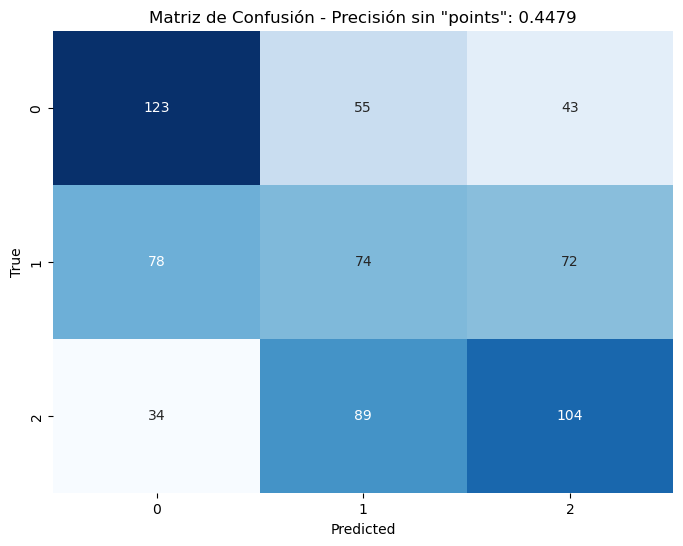

In [16]:
# Generar la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred_sin_points)

# Graficar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title(f'Matriz de Confusión - Precisión sin "points": {accuracy_sin_points:.4f}')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [17]:
# Calcular la precisión global (accuracy) para el modelo sin 'points'
accuracy_sin_points = accuracy_score(y_test, y_pred_sin_points)
print(f"Precisión global (Accuracy) sin 'points': {accuracy_sin_points:.4f}")

# Calcular precision, recall, f1-score para cada clase
precision_sin_points = precision_score(y_test, y_pred_sin_points, average='weighted')  # Usa 'weighted' para multiclase
recall_sin_points = recall_score(y_test, y_pred_sin_points, average='weighted')
f1_sin_points = f1_score(y_test, y_pred_sin_points, average='weighted')

print(f"Precisión (Precision) sin 'points': {precision_sin_points:.4f}")
print(f"Recall sin 'points': {recall_sin_points:.4f}")
print(f"F1-Score sin 'points': {f1_sin_points:.4f}")

# Mostrar un informe completo
print("\nInforme de clasificación (Classification Report) sin 'points':")
print(classification_report(y_test, y_pred_sin_points))

StatementMeta(, 1cde3a7a-90d2-434b-abb5-25854137a9cc, 19, Finished, Available, Finished)

Precisión global (Accuracy) sin 'points': 0.4479
Precisión (Precision) sin 'points': 0.4457
Recall sin 'points': 0.4479
F1-Score sin 'points': 0.4466

Informe de clasificación (Classification Report) sin 'points':
              precision    recall  f1-score   support

           1       0.52      0.56      0.54       221
           2       0.34      0.33      0.33       224
           3       0.47      0.46      0.47       227

    accuracy                           0.45       672
   macro avg       0.45      0.45      0.45       672
weighted avg       0.45      0.45      0.45       672



**Grid Search sin points**

In [25]:
# Definir los hiperparámetros a probar en GridSearch
param_grid = {
    'n_estimators': [50, 100, 200],           # Número de árboles
    'max_depth': [None, 5, 10, 20],           # Profundidad máxima de los árboles
    'min_samples_split': [2, 5, 10],          # Número mínimo de muestras para dividir un nodo
    'min_samples_leaf': [1, 2, 4],            # Muestras mínimas por hoja
    'bootstrap': [True, False]                # Si se usa muestreo con reemplazo
}

# Instanciar el modelo RandomForestClassifier
rf = RandomForestClassifier(random_state=42)

# Configurar GridSearchCV con validación cruzada
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# Ajustar el modelo con GridSearch
grid_search.fit(X_train_sin_points, y_train)

# Mostrar los mejores hiperparámetros encontrados
print(f"Mejores hiperparámetros: {grid_search.best_params_}")
print(f"Mejor precisión durante la validación cruzada: {grid_search.best_score_:.4f}")

# Evaluar el modelo en el conjunto de prueba
y_pred_sin_points = grid_search.best_estimator_.predict(X_test_sin_points)
accuracy_sin_points = accuracy_score(y_test, y_pred_sin_points)

# Mostrar la precisión en el conjunto de prueba
print(f"Precisión del modelo sin 'points' en el conjunto de prueba: {accuracy_sin_points:.4f}")

StatementMeta(, 368adb01-9d77-4bc4-ac09-767824b0e58f, 27, Finished, Available, Finished)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.5s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.5s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.5s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.5s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.0s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.0s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.6s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total ti

In [26]:
# Mostrar los mejores hiperparámetros encontrados
print(f"Mejores hiperparámetros: {grid_search.best_params_}")
print(f"Mejor precisión durante la validación cruzada: {grid_search.best_score_:.4f}")

# Mostrar la precisión en el conjunto de prueba
print(f"Precisión del modelo sin 'points' en el conjunto de prueba: {accuracy_sin_points:.4f}")

StatementMeta(, 368adb01-9d77-4bc4-ac09-767824b0e58f, 28, Finished, Available, Finished)

Mejores hiperparámetros: {'bootstrap': False, 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
Mejor precisión durante la validación cruzada: 0.5171
Precisión del modelo sin 'points' en el conjunto de prueba: 0.4896


Probando otros valores para entrenar el modelo

In [33]:
# Definir los hiperparámetros a probar aleatoriamente
param_dist = {
    'n_estimators': randint(100, 500),
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10),
    'bootstrap': [True, False]
}

# Búsqueda aleatoria
random_search = RandomizedSearchCV(estimator=RandomForestClassifier(random_state=42),
                                   param_distributions=param_dist,
                                   n_iter=100, cv=5, verbose=2, n_jobs=-1)

random_search.fit(X_train_sin_points, y_train)

# Evaluar el modelo con los mejores hiperparámetros
y_pred = random_search.best_estimator_.predict(X_test_sin_points)
accuracy = accuracy_score(y_test, y_pred)
print(f"Mejor precisión después de RandomizedSearch: {accuracy:.4f}")

StatementMeta(, 368adb01-9d77-4bc4-ac09-767824b0e58f, 35, Finished, Available, Finished)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=2, min_samples_split=14, n_estimators=213; total time=   1.6s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=2, min_samples_split=14, n_estimators=213; total time=   1.7s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=2, min_samples_split=14, n_estimators=213; total time=   1.7s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=2, min_samples_split=14, n_estimators=213; total time=   1.9s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=2, min_samples_split=14, n_estimators=213; total time=   2.0s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=158; total time=   1.0s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=158; total time=   1.5s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=158; total time

In [34]:
print(f"Mejor precisión después de RandomizedSearch: {accuracy:.4f}")

StatementMeta(, 368adb01-9d77-4bc4-ac09-767824b0e58f, 36, Finished, Available, Finished)

Mejor precisión después de RandomizedSearch: 0.5000


El modelo entrenado con RandomizedSearchCV obtuvo una precisión de 0.5000 en el conjunto de prueba. Aunque es una ligera mejora con respecto a las iteraciones anteriores, la precisión sigue siendo baja. Esto sugiere que, a pesar de los ajustes en los hiperparámetros, el modelo tiene dificultades para capturar las relaciones clave sin la variable points. Es posible que la estructura actual de las características no sea suficiente para mejorar el rendimiento significativamente, lo que refuerza la importancia de la variable excluida o de generar nuevas características derivadas.


**Entrenar otros modelos**

**Gradient Boosting Machines (GBM)**

Los modelos de boosting suelen funcionar mejor que los Random Forest en muchos problemas de clasificación, especialmente cuando hay características con interacciones complejas. Dos de los más populares son XGBoost y LightGBM.



**LightGBM**

In [25]:
import lightgbm as lgb

# Entrenar el modelo LightGBM
lgb_model = lgb.LGBMClassifier(random_state=42)
lgb_model.fit(X_train_sin_points, y_train)

# Evaluar el modelo
y_pred_lgb = lgb_model.predict(X_test_sin_points)
accuracy_lgb = accuracy_score(y_test, y_pred_lgb)
print(f"Precisión del modelo LightGBM: {accuracy_lgb:.4f}")

StatementMeta(, 1cde3a7a-90d2-434b-abb5-25854137a9cc, 27, Finished, Available, Finished)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000554 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 723
[LightGBM] [Info] Number of data points in the train set: 2688, number of used features: 9
[LightGBM] [Info] Start training from score -1.099729
[LightGBM] [Info] Start training from score -1.097497
[LightGBM] [Info] Start training from score -1.098612
Precisión del modelo LightGBM: 0.4554


**Support Vector Machines (SVM)**

Los Support Vector Machines (SVM) son excelentes para problemas con fronteras de decisión complejas. Son efectivos para conjuntos de datos con características limitadas y pueden manejar bien problemas de clasificación multiclase.



In [20]:
# Entrenar el modelo SVM
svm_model = SVC(kernel='rbf', random_state=42)
svm_model.fit(X_train_sin_points, y_train)

# Evaluar el modelo
y_pred_svm = svm_model.predict(X_test_sin_points)
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print(f"Precisión del modelo SVM: {accuracy_svm:.4f}")

StatementMeta(, 1cde3a7a-90d2-434b-abb5-25854137a9cc, 22, Finished, Available, Finished)

Precisión del modelo SVM: 0.3616


**Redes Neuronales (Multilayer Perceptron - MLP)**

Un MLP (Multilayer Perceptron) es una red neuronal básica de tipo feedforward. Las redes neuronales son más flexibles y pueden aprender patrones complejos, aunque requieren un ajuste cuidadoso de los hiperparámetros.



In [21]:
from sklearn.neural_network import MLPClassifier

# Entrenar el modelo MLP
mlp_model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42)
mlp_model.fit(X_train_sin_points, y_train)

# Evaluar el modelo
y_pred_mlp = mlp_model.predict(X_test_sin_points)
accuracy_mlp = accuracy_score(y_test, y_pred_mlp)
print(f"Precisión del modelo MLP: {accuracy_mlp:.4f}")

StatementMeta(, 1cde3a7a-90d2-434b-abb5-25854137a9cc, 23, Finished, Available, Finished)

Precisión del modelo MLP: 0.3988


**K-Nearest Neighbors (KNN)**

El KNN es un modelo basado en instancias que clasifica un punto basándose en la clase de sus vecinos más cercanos. Es simple, pero puede ser muy efectivo si las características están bien separadas.



In [22]:
from sklearn.neighbors import KNeighborsClassifier

# Entrenar el modelo KNN
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train_sin_points, y_train)

# Evaluar el modelo
y_pred_knn = knn_model.predict(X_test_sin_points)
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print(f"Precisión del modelo KNN: {accuracy_knn:.4f}")

StatementMeta(, 1cde3a7a-90d2-434b-abb5-25854137a9cc, 24, Finished, Available, Finished)

Precisión del modelo KNN: 0.3884


**Naive Bayes**

El modelo de Naive Bayes es un clasificador probabilístico que asume que las características son independientes entre sí. Aunque esta suposición es a menudo poco realista, el modelo puede ser rápido y efectivo en algunos problemas.



In [23]:
from sklearn.naive_bayes import GaussianNB

# Entrenar el modelo Naive Bayes
nb_model = GaussianNB()
nb_model.fit(X_train_sin_points, y_train)

# Evaluar el modelo
y_pred_nb = nb_model.predict(X_test_sin_points)
accuracy_nb = accuracy_score(y_test, y_pred_nb)
print(f"Precisión del modelo Naive Bayes: {accuracy_nb:.4f}")

StatementMeta(, 1cde3a7a-90d2-434b-abb5-25854137a9cc, 25, Finished, Available, Finished)

Precisión del modelo Naive Bayes: 0.3839


**Logistic Regression**

La Regresión Logística es un modelo simple y efectivo para la clasificación binaria y multiclase. A veces puede ser más eficaz que modelos más complejos, sobre todo si las características no son altamente no lineales.



In [24]:
from sklearn.linear_model import LogisticRegression

# Entrenar el modelo de Regresión Logística
log_model = LogisticRegression(max_iter=500, random_state=42)
log_model.fit(X_train_sin_points, y_train)

# Evaluar el modelo
y_pred_log = log_model.predict(X_test_sin_points)
accuracy_log = accuracy_score(y_test, y_pred_log)
print(f"Precisión del modelo Regresión Logística: {accuracy_log:.4f}")

StatementMeta(, 1cde3a7a-90d2-434b-abb5-25854137a9cc, 26, Finished, Available, Finished)

Precisión del modelo Regresión Logística: 0.4732


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Crear el modelo de regresión logística multiclase
lr_model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=200, random_state=42)

# Entrenar el modelo con los datos de entrenamiento
lr_model.fit(X_train_sin_points, y_train)

# Hacer predicciones en los datos de prueba
y_pred = lr_model.predict(X_test_sin_points)

# Evaluar el modelo
accuracy = accuracy_score(y_test, y_pred)
print(f"Precisión del modelo de Regresión Logística: {accuracy:.4f}")

# Mostrar la matriz de confusión
print("Matriz de Confusión:")
print(confusion_matrix(y_test, y_pred))

# Mostrar el informe de clasificación
print("Informe de clasificación:")
print(classification_report(y_test, y_pred))

StatementMeta(, 1cde3a7a-90d2-434b-abb5-25854137a9cc, 28, Finished, Available, Finished)

Precisión del modelo de Regresión Logística: 0.4762
Matriz de Confusión:
[[159  37  25]
 [114  59  51]
 [ 57  68 102]]
Informe de clasificación:
              precision    recall  f1-score   support

           1       0.48      0.72      0.58       221
           2       0.36      0.26      0.30       224
           3       0.57      0.45      0.50       227

    accuracy                           0.48       672
   macro avg       0.47      0.48      0.46       672
weighted avg       0.47      0.48      0.46       672



/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
